# Model NEATM + REFLECT MODEL @python3.8
$D_{eff}=\frac{1329\times10^{-H_v/5}}{\sqrt{p_v}}$
$p_v=\frac{A_B}{q}$
$q_s=\frac{F_{sun}}{d^2}$
$T_{fit}=[\frac{(1-A)F_{sun}}{\eta\epsilon\sigma d}]^{1/4}$
$T=T(\theta,\phi)=T_{fit}\cos^{1/4}\theta\cos^{1/4}\phi,(-\frac{\pi}{2}<\theta<\frac{\pi}{2},-\frac{\pi}{2}<\phi<\frac{\pi}{2})$
$F_\lambda=F(\Delta,d,\alpha|\eta,D)$

$F_\lambda=\frac{\epsilon D^2}{2\Delta ^2}\frac{\pi h c^2}{\lambda ^5}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\frac{1}{exp(\frac{hc}{\lambda kT(\theta,\phi)}-1)}\cos^2 \phi\cos(\alpha-\theta)d\theta$

$F_\lambda=\frac{\epsilon D^2}{4\Delta ^2}\int_{-\pi/2}^{\pi/2}d\phi\int_{\alpha-\pi/2}^{\pi/2}\pi B(T,\lambda)\cos^2 \phi\cos(\alpha-\theta)d\theta$


# MCMC_NEATM

## define const & import

In [1]:
#import
import numpy as np
import matplotlib.pyplot as plt
import math as mh 
import pandas as pd
from tqdm import tqdm
import os
#import NEATM
from NEATM import *
#constant
Fsun = 1367.5           # sun constant
sigma = 5.67E-8         #stefan-boltzmann constant
h = 6.626007015E-34     #plank constant
#q = 0.29+0.684*0.15    #phase integral = 0.29+0.684*G(=0.15)
epsi = 0.9             #radiance epsilon
kB = 1.38064852E-23     #boltzmann constant  j/k
cl = 299792458.0        #lightspeed m/s
au = 149597870700.0
pi = 3.1415926535
Rsun = 0.00465*au   #Rsun *m
Tsun = 5778         #Tsun  K
Hv = 21.5
G = 0.15
Ndd = 15
lamdai = [3.4,4.6,12,22]

## define MODEL FUNCTION
initial x:flux = delta, it will change "delta"!
list: a,b
a = b
a = b[:]

### Model hhq

In [36]:
def neatm_ohhq(Ndd,eta,D,delta,dd,alpha,lamda,A):   
    summ = 0.
    a = alpha-pi/2
    b = pi/2
    c = -pi/2          
    d = pi/2
    Tfit = np.power((1-A)*Fsun/(eta*epsi*sigma*dd*dd),0.25)
    #print(f"Tss = {Tfit-273}\n")
    dxdy = ((b-a)*(d-c)/(Ndd*Ndd)) 
    for j in range(Ndd):
        for i in range(Ndd):
            phii = (c+(d-c)*j/Ndd)
            thei = (a+(b-a)*i/Ndd)
            T = Tfit*np.power(np.cos(thei),0.25)*np.power(np.cos(phii),0.25)
            integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
            summ = summ + dxdy*integral
    F = (epsi*np.power(D,2)*pi*h*cl*cl)*summ/(2*np.power(delta*au,2)*np.power(lamda,5))
    F = F*(lamda)**2/cl*1e29
    return F
def Model_neatm_Ref_jhx(theta,x,lamda):
    '''
    theta = (eta,D,wf)
    x = (astp,obsp)
    x = (3.4x;4.6x;12x;22x)
    '''
    eta,D,wf = theta
    astp,obsp = x
    lamda1,lamda2,lamda3,lamda4 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial
    nn = len(astp)
    #print(nn)
    qutn = int(nn/4)
    flux = np.zeros(nn)
    #w1,w2 with Ref
    for i in range(qutn):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda1,eta,A)
        flux[i] = fluxi + wf*frLambi + frLommi
    for i in range(qutn,qutn*2):
        fluxi,frLambi,frLommi = get_flux_ref(astp[i],obsp[i],D,lamda2,eta,A)
        flux[i] = fluxi + wf*frLambi + frLommi
    #w3,w3 without Ref
    for i in range(qutn*2,qutn*3):
        flux[i] = get_flux_noref(astp[i],obsp[i],D,lamda3,eta,A)
        #flux[i] ,frLambi,frLommi= get_flux_ref(astp[i],obsp[i],D,lamda3,eta,A)
    for i in range(qutn*3,qutn*4):
        flux[i] = get_flux_noref(astp[i],obsp[i],D,lamda3,eta,A)
        #flux[i] ,frLambi,frLommi= get_flux_ref(astp[i],obsp[i],D,lamda4,eta,A)
    return flux
    
def Model_neatm_ohhq(theta,x,lamda):
    eta,D = theta
    delta,d,alpha = x
    lamda1,lamda2 = lamda
    pv = (1329*pow(10,-Hv/5)/(D*0.001))**2
    q = 0.29+0.684*G
    A = q*pv
    #initial flux
    flux = np.zeros(len(delta))
    nn = int(len(flux))
    for i in range(0,(int(nn/2))-1):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda1*1e-6,A)
    for i in range(int(nn/2),nn):
        flux[i] = neatm_ohhq(Ndd,eta,D,delta[i],d[i],alpha[i],lamda2*1e-6,A)
    return flux

### Model reflect

In [3]:
import NEATM
# -*- coding: utf-8 -*-
from re import DOTALL
import matplotlib as mpl
from numpy import *
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import norm
from scipy import integrate
from matplotlib.ticker import FuncFormatter
import NEATM
from NEATM import *
# #loading position files:
wlen = np.loadtxt('ObsWLs.txt')
epoch = np.loadtxt('ObsECs.txt')
#fobs = np.loadtxt('fobs.txt')
w12 = np.loadtxt('w12_2010co1.txt')
w34 = np.loadtxt('w34_2010co1.txt')
w1 = w12[0:32]
w2 = w12[32:64]
w3 = w34[0:32]
w4 = w34[32:64]
fobs = np.zeros((len(w1)*4,3))
for i in range(0,len(w1)):
    fobs[i*4+0,0:3] = [3.4,w1[i],w1[i]*0.1]
    fobs[i*4+1,0:3] = [4.6,w2[i],w2[i]*0.1]
    fobs[i*4+2,0:3] = [11.98,w3[i],w3[i]*0.1]
    fobs[i*4+3,0:3] = [22.0,w4[i],w4[i]*0.1]


def para_fit(yita,Dia,wf,A,epoch,wlen):
    flux = []
    frLamb = []
    frLomm = []
    w_final = []
    for i in range(0,len(wlen)):
        astp = epoch[i,0:3]
        obsp = epoch[i,3:6]
        for j in range(0,len(wlen[0,:])):
            wl = wlen[i,j]
            if wl != 0:
                #print(wl,astp,obsp)
                ff = get_flux_ref(astp,obsp,Dia,wl,yita,A) #flux and reflected sunlight
                print(f'f={ff},astp={astp},wl={wl}')
                flux.append(ff[0])
                frLamb.append(ff[1])
                frLomm.append(ff[2])
                w_final.append(wl)
    flux = np.array(flux)
    frLamb = np.array(frLamb)
    frLomm = np.array(frLomm)
    fref = wf * frLamb + frLomm
    w_final = np.array(w_final)
    return flux,fref,w_final

# for i in range(len(fobs)-1,-1,-1):
#     if fobs[i,0] == 3.4 or fobs[i,0]== 4.6:
#         fobs = np.delete(fobs,i,axis=0)

chiall = []  
Dall = []
yita_all = []
for wf in range(0,11):
    wf = wf * 0.05
    for D in range(280,500,10):
        #variables---------------------------------------------------------------------------
        #slope parameter:
        G = 0.15
        #abs magnitude
        mag = 21.5
        #geometric albedo:
        pv = (1329*10**(-mag/5)/D*1000)**2
        #phase integral
        qph = 0.15 + 0.684 * G
        #bond albedo
        A = pv * qph
        for yita in range(80,450,5):
            yita = yita * 0.01
            fm,fref,wfinal = para_fit(yita,D,wf,A,epoch,wlen)
            chi2 = 0
            for i in range(0,len(fm)):
                chi2 = chi2 +  ((fm[i]+fref[i] - fobs[i,1])/(fobs[i,1]*0.1))**2
            #chi2 = 1/(len(wlen)*2-3) * sum(((fm - fobs[:,1])/(fobs[:,1]*0.1))**2)
            chi2 = chi2/(len(fobs)-3)
            chiall.append(chi2)
            print(chi2,D,yita,wf)
            break 
        break
    break
chiall = np.array(chiall)
n = np.where(chiall == chiall.min())
'''
k = 0
chif = []
d1 = []
yita1 = []
for nw in range(0,11):
    for i in range(280,500,10):
        for j in range(80,450,5):
            k = k + 1
            if chiall[k-1] <= chiall.min() + 1:
                d1.append(i+10)
                yita1.append((j+1)*0.05)
            if k == n[0]:
                #print(i,j)
                nnw = nw
                nd = i
                ny = j
                
D_final = nd + 10
yita_final = (ny + 5) * 0.01
nw_final = (nnw+1) * 0.05
pv_final = (1329*10**(-mag/5)/D_final*1000)**2
A_final = pv_final * qph

flux_final,fref,w_final = para_fit(yita_final,D_final,nw_final,A_final,epoch,wlen)'''


/home/astrohhq/learngit/JHX2010CO1/NEATM.py:187: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


f=(0.2574311283637495, 0.0035577239388749266, 0.005931999601044901),astp=[-0.5339575   0.90480846  0.36328469],wl=3.4
f=(1.9370469250859037, 0.0021602789184596003, 0.003601958415722533),astp=[-0.5339575   0.90480846  0.36328469],wl=4.6
f=(21.46331161134894, 0.00037906848178934706, 0.00063204287948609),astp=[-0.5339575   0.90480846  0.36328469],wl=12.0
f=(18.490677395592897, 0.00011838006281826987, 0.00019738194909853425),astp=[-0.5339575   0.90480846  0.36328469],wl=22.0
f=(0.6895896706897547, 0.008429362518723725, 0.022050244107269825),astp=[-0.77958501  0.63253017  0.22746359],wl=3.4
f=(4.782467415091953, 0.005118377495869152, 0.013389087604949673),astp=[-0.77958501  0.63253017  0.22746359],wl=4.6
f=(46.86120300173164, 0.0008981319819421097, 0.0023494101005123295),astp=[-0.77958501  0.63253017  0.22746359],wl=12.0
f=(39.28927025612501, 0.0002804794530516734, 0.0007337020318114551),astp=[-0.77958501  0.63253017  0.22746359],wl=22.0
f=(0.689594646443694, 0.008429414980681832, 0.0220504

'\nk = 0\nchif = []\nd1 = []\nyita1 = []\nfor nw in range(0,11):\n    for i in range(280,500,10):\n        for j in range(80,450,5):\n            k = k + 1\n            if chiall[k-1] <= chiall.min() + 1:\n                d1.append(i+10)\n                yita1.append((j+1)*0.05)\n            if k == n[0]:\n                #print(i,j)\n                nnw = nw\n                nd = i\n                ny = j\n                \nD_final = nd + 10\nyita_final = (ny + 5) * 0.01\nnw_final = (nnw+1) * 0.05\npv_final = (1329*10**(-mag/5)/D_final*1000)**2\nA_final = pv_final * qph\n\nflux_final,fref,w_final = para_fit(yita_final,D_final,nw_final,A_final,epoch,wlen)'

## read data file

#### 处理原始数据 将坐标垂直叠加，方便直接计算12，22微米的流量

In [4]:
namelist = ['2003MA3','2010CO1','2010DG77','2010EX11','2010FC81','2010FH81','2010GS7','2010JN71','2010KX7','2010PW58','2010XP69','2019DD2']
name = '2010co1'

#### read data & cal  
$x\equiv \Delta,d,\alpha$

In [32]:
obsec = np.loadtxt(f'newepoch_{name}.txt')
name = namelist[1].lower()
obsec = np.loadtxt(f'newepoch_{name}.txt')
obsdat12 = np.loadtxt(f'w12_{name}.txt')
obsdat34 = np.loadtxt(f'w34_{name}.txt')
#ast-sun
d_N = np.sqrt(obsec[:,0]**2+obsec[:,1]**2+obsec[:,2]**2)
#print('ast-sun',d_N)
#ast-earth
delta_N = np.sqrt((obsec[:,3]-obsec[:,0])**2+(obsec[:,4]-obsec[:,1])**2+(obsec[:,5]-obsec[:,2])**2)
#print('ast-earth',delta_N)
#earth-sun
dd_N = np.sqrt(obsec[:,3]**2+obsec[:,4]**2+obsec[:,5]**2)
#print('earth-sun',dd_N)
#alpha
alpha_N = (delta_N*delta_N+d_N*d_N-dd_N*dd_N)/(2*delta_N*d_N)
alpha_N = np.arccos(alpha_N)
#print("alpha",alpha_N/pi*180,'\n')
x = (delta_N,d_N,alpha_N)
x1 = np.vstack((obsec[:,0:3],obsec[:,0:3]))
x2 = np.vstack((obsec[:,3:6],obsec[:,3:6]))
x_jhx = (x1,x2)
astpp,obss = x_jhx
y = np.vstack((obsdat12,obsdat34))

In [37]:
Dtest = 346
pv = (1329*pow(10,-Hv/5)/(Dtest*0.001))**2
q = 0.29+0.684*G
At = q*pv
fluxi,frLambi,frLommi = get_flux_ref(x_jhx[0][0],x_jhx[1][0],346,3.4,1.2,A)
print(fluxi)
print(Model_neatm_Ref_jhx((1.2,346,1),x_jhx,lamdai))

0.12004439799688554
[ 0.13469833  0.38009557  0.3800985   0.38313815  0.38620699  0.38930535
  0.39559473  0.39718674  0.39878335  0.40039071  0.40200266  0.40200577
  0.4036255   0.40525614  0.40689146  0.40689461  0.40853781  0.4101921
  0.41185112  0.41185434  0.41352136  0.41519964  0.41688274  0.416886
  0.41857721  0.4219874   0.42370649  0.43066281  0.43418985  0.43775099
  0.44135009  0.52999625  1.22484357  3.10373433  3.10375569  3.12592382
  3.14827239  3.17080264  3.21643381  3.22796221  3.23951491  3.25113627
  3.26278165  3.26280408  3.2744963   3.28625783  3.29804348  3.29806617
  3.30989902  3.3218018   3.33372879  3.33375194  3.3457263   3.3577714
  3.36984077  3.36986419  3.38198128  3.40638246  3.41866696  3.46826423
  3.49334207  3.51861469  3.54410756  4.15511223 22.71026996 49.93352692
 49.93382234 50.24031276 50.54906956 50.86010618 51.48935686 51.64818552
 51.80728999 51.96728063 52.12754253 52.12785106 52.28869768 52.45043746
 52.61244869 52.61276058 52.7753600

/home/astrohhq/learngit/JHX2010CO1/NEATM.py:187: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/home/astrohhq/learngit/JHX2010CO1/NEATM.py:115: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


##### plot $F_v^{ref}-\lambda$

In [18]:
astp,obsp = obsec[:,0:3],obsec[:,3:6]
delta0,d0,alpha0 = x[0][0],x[1][0],x[2][0]
arraylam = np.linspace(0,22,100)
#refledF = NEATM.get_flux_ref(346,delta0,d0,alpha0,arraylam*1e-6,0.9)
Dtest = 346
pv = (1329*pow(10,-Hv/5)/(Dtest*0.001))**2
q = 0.29+0.684*G
At = q*pv
refledF = NEATM.get_flux_ref(astp[0],obsp[0],Dtest,3.4,1.2,At)
flux = neatm_ohhq(10,1.2,Dtest,delta0,d0,alpha0,3.4e-6,At)
print(Model_neatm_Ref_jhx((1.2,346,0.2),x_jhx,lamdai))


64
[ 0.21759766  0.54258046  0.54258362  0.5458515   0.54913081  0.55242125
  0.55903727  0.56069847  0.56235897  0.56402508  0.56569035  0.56569355
  0.56736117  0.56903426  0.57070634  0.57070956  4.8508447   4.8636742
  4.87648628  4.8765111   4.88933001  4.90218003  4.91501092  4.91503578
  4.92787181  4.95358181  4.96645458  5.01794188  5.04367682  5.06940674
  5.09515088  5.64423878 35.03918758 68.54527336 68.54560957 68.89366252
 69.24277352 69.59291387 70.2964783  70.47304155 70.64949511 70.8265098
 71.00339915 71.00373928 71.18084348 71.35849541 71.53600586 71.53634717
 71.71405725 71.89230067 72.07038564 72.07073073 72.24899647 72.42778283
 72.60639288 72.60673897 72.78551266 73.14387319 73.3234484  74.04273079
 74.40290467 74.76347126 75.12472203 83.00463001]


/home/astrohhq/learngit/JHX2010CO1/NEATM.py:187: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/tmp/ipykernel_662151/1674960078.py:15: RuntimeWarning: overflow encountered in exp
  integral = np.cos(phii)**2*np.cos(alpha-thei)/(np.exp(h*cl/(lamda*kB*T))-1)
/home/astrohhq/learngit/JHX2010CO1/NEATM.py:115: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


#### cal Flex
$F_v^{ast}(\lambda) = F_v^{th}(\lambda) + F_v^{ref}$


##### cal $F_v^{th}+F_v^{ref}$ in W1\W2

In [41]:
flux1234= Model_neatm_Ref_jhx((1.2,200,0.4),x_jhx,lamdai)
nt = len(flux1234)

/home/astrohhq/learngit/JHX2010CO1/NEATM.py:187: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/home/astrohhq/learngit/JHX2010CO1/NEATM.py:115: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


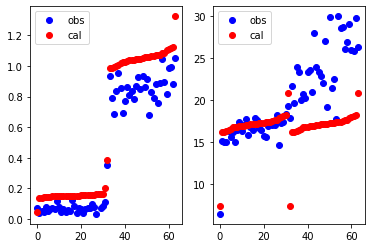

In [45]:
y12 = obsdat12
flux12 = flux1234[0:nt//2]
plt.subplot(1,2,1)
plt.plot(y12,'bo',label = 'obs')
plt.plot(flux12,'ro',label = 'cal')
plt.legend()
y34 = obsdat34
flux34 = flux1234[nt//2:]
plt.subplot(1,2,2)
plt.plot(y34,'bo',label = 'obs')
plt.plot(flux34,'ro',label = 'cal')
plt.legend()

# MCMC

In [46]:
#initial
eta_gs = 1.2
D_gs = 150
eta_gss = [0.5,5]
D_gss = [1,500]
wf_gs = 0.2
wf_gss = [0,0.5]

In [50]:
#MCMC Function
def log_likelihood(theta, x, y, yerr):
    eta,D,wf = theta
    model = Model_neatm_Ref_jhx(theta,x,lamdai)
    #model = eta*x[0]*100 + D
    sigma2 = yerr ** 2
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))
def log_prior(theta):
    eta,D,wf = theta
    if eta_gss[0]< eta < eta_gss[1] and D_gss[0] < D < D_gss[1] and wf_gss[0] < wf < wf_gss[1]:
        return 0.0
    return -np.inf
    #return 0
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
     #   print('hi','-inf')
        return -np.inf
    yy=lp + log_likelihood(theta, x, y, yerr)
    #print('hi',yy)
    return yy


In [48]:
#initial para guesses
eta = eta_gs
D = D_gs
wf = wf_gs
theta = [eta, D,wf]

In [51]:
import emcee
#initialize sampler
ndim, nwalkers = len(theta), 10
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x_jhx, y, y*0.1))
pos = [theta + 1e-6*np.random.randn(ndim) for i in range(nwalkers)]
#run mcmc
sampler.run_mcmc(pos, 1000, progress=True);

/home/astrohhq/learngit/JHX2010CO1/NEATM.py:187: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/home/astrohhq/learngit/JHX2010CO1/NEATM.py:115: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
100%|██████████| 1000/1000 [16:44<00:00,  1.00s/it]


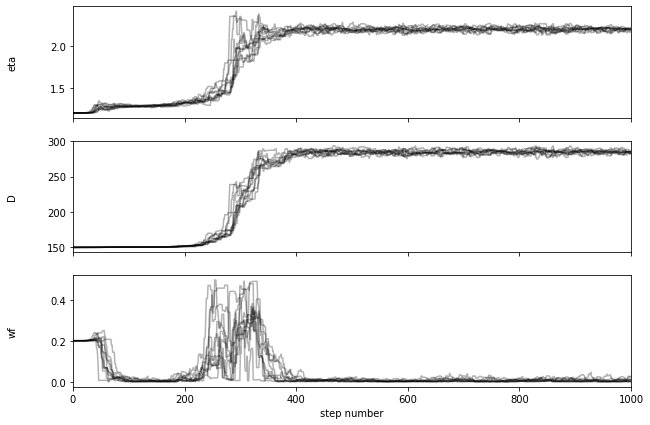

In [52]:
fig, axes = plt.subplots(3, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["eta", "D", "wf"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");

(260, 3)


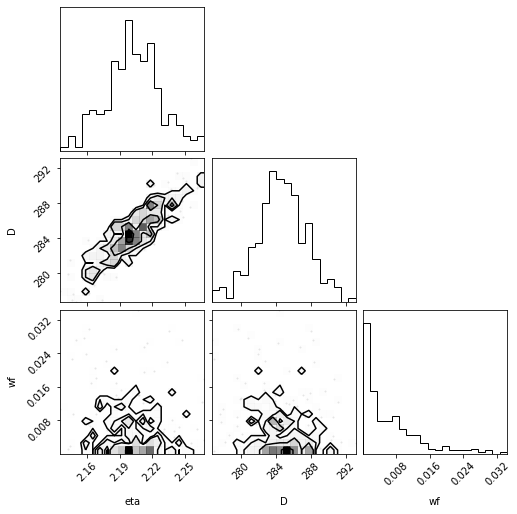

In [54]:
#--------------------------
flat_samples = sampler.get_chain(discard=600, thin=15, flat=True)
print(flat_samples.shape)
import corner
fig = corner.corner(
flat_samples, labels=labels, truths=[eta_gs, D_gs,wf_gs]
);

In [55]:
from IPython.display import display, Math
for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    #print(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))
print(Math(txt))
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
pv = (1329*pow(10,-Hv/5)/(D_fit*0.001))**2
print('eta_gs = ',eta_gs,'D_gs= ',D_gs,'pv=',pv)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>
eta_gs =  1.2 D_gs=  150 pv= 0.0548185971305858


In [58]:
def loss(obs,cal,err):
    l = len(obs)
    return sum(((obs-cal)/err)**2)/l
print('LossFunction = ',loss(y,Model_neatm_Ref_jhx(theta,x_jhx,lamdai),y*0.1))

LossFunction =  30.575482027542883


/home/astrohhq/learngit/JHX2010CO1/NEATM.py:187: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/home/astrohhq/learngit/JHX2010CO1/NEATM.py:115: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


In [70]:
import pandas as pd
rawdata = pd.read_csv(f'time_{name}.txt')
timelist = rawdata['mjd'].tolist()
yerr = y*0.1

eta_fit =  2.202194582557526 D_fit=  284.4860808097791 pv =  0.0548185971305858


/home/astrohhq/learngit/JHX2010CO1/NEATM.py:187: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy
/home/astrohhq/learngit/JHX2010CO1/NEATM.py:115: RuntimeWarning: overflow encountered in exp
  flux = flux + flux_con * math.cos(phi[j])**2 * np.abs(math.cos(alpha - theta[k]))  / (exp(h * c / (wlenth * kb * temp[j,k])) - 1) * dphi * dtheta * wlenth ** 2 / c * 10 ** 29 # obtain flux in unit of mjy


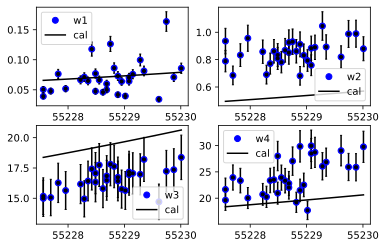

In [84]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
def loss(cal,y,yerr):
    nn = len(y)
    return sum(((cal-y)/yerr)**2)/nn
eta_low,eta_fit,eta_high = np.percentile(flat_samples[:, 0], [16, 50, 84])
D_low,D_fit,D_high = np.percentile(flat_samples[:, 1], [16, 50, 84])
wf_low,wf_fit,wf_high = np.percentile(flat_samples[:, 2], [16, 50, 84])

print('eta_fit = ',eta_fit,'D_fit= ',D_fit,'pv = ',(1329*pow(10,-Hv/5)/(D_fit*0.001))**2)
theta = eta_fit,D_fit,wf_fit
flux = Model_neatm_Ref_jhx(theta,x_jhx,lamdai)
qq = nt//4
y12 = obsdat12
flux12 = flux[0:nt//2]
plt.subplot(2,2,1)
plt.plot(timelist[1:qq-1],y12[1:qq-1],'bo',label = 'w1')
plt.errorbar(timelist[1:qq-1],y12[1:qq-1],yerr[1:qq-1],fmt=".k", capsize=1.0)
plt.plot(timelist[1:qq-1],flux12[1:qq-1],'k',label = 'cal')
plt.legend()
plt.subplot(2,2,2)
plt.plot(timelist[1:qq-1],y12[qq+1:2*qq-1],'bo',label = 'w2')
plt.errorbar(timelist[1:qq-1],y12[qq+1:2*qq-1],yerr[qq+1:2*qq-1],fmt=".k", capsize=1.0)
plt.plot(timelist[1:qq-1],flux12[qq+1:2*qq-1],'k',label = 'cal')
plt.legend()
y34 = obsdat34
flux34 = flux[nt//2:]
plt.subplot(2,2,3)
plt.plot(timelist[1:qq-1],y34[1:qq-1],'bo',label = 'w3')
plt.errorbar(timelist[1:qq-1],y34[1:qq-1],y34[1:qq-1]*0.1,fmt=".k", capsize=1.0)
plt.plot(timelist[1:qq-1],flux34[1:qq-1],'k',label = 'cal')
plt.legend()
plt.subplot(2,2,4)
plt.plot(timelist[1:qq-1],y34[qq+1:2*qq-1],'bo',label = 'w4')
plt.errorbar(timelist[1:qq-1],y34[qq+1:2*qq-1],y34[qq+1:2*qq-1]*0.1,fmt=".k", capsize=1.0)
plt.plot(timelist[1:qq-1],flux34[qq+1:2*qq-1],'k',label = 'cal')
plt.legend()

